In [ ]:
from PIL import Image
from pathlib import Path
from fastai.basics import *
from fastai.text.all import *
from transformers import ReformerModelWithLMHead, ReformerTokenizerFast
from fastai.callback.wandb import *
import wandb
from text2anime.data_loading import *

In [ ]:
path=Path('./danbooru2020')
image_path=path/'512px/'
meta=path/'meta'

In [ ]:
with open('named_tags.pkl','rb') as f: named_tags=pickle.load(f)
with open('id_tags.pkl','rb') as f: id_tags=pickle.load(f)
full_table = pd.read_pickle('fulll_table.pkl')

In [ ]:
#I forget why we do this, but needed to be done for dataloader, might be fastai bug? 
@patch
@delegates(TfmdDL.new)
def new(self:SortedDL, dataset=None, **kwargs):
    res = self.res if dataset is None else None
    
    return super(SortedDL, self).new(dataset=dataset, **merge({'res':res}, kwargs))

In [ ]:
from transformers import ReformerModelWithLMHead, ReformerTokenizerFast

pretrained_weights = 'google/reformer-crime-and-punishment'
tokenizer = ReformerTokenizerFast.from_pretrained(pretrained_weights)
model = ReformerModelWithLMHead.from_pretrained(pretrained_weights)

Some weights of ReformerModelWithLMHead were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.5.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.4.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.5.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.5.

Just take the decoder, cover up the image with black pixels, and predict missing pixels. 

MAybe try Albert+Fnet techniques? (Albert is encoder we need decoder), Reformer???

Albert explanation: https://www.youtube.com/watch?v=vsGN8WqwvKg

Use reformer!!!

In [ ]:
id_tag_df=pd.DataFrame.from_dict(id_tags,orient='index',columns=['tag'])

In [ ]:
def tokenize_df(df, text_cols, n_workers=defaults.cpus, rules=None, mark_fields=None,
                tok=None, tok_text_col="text"):
    "Tokenize texts in `df[text_cols]` in parallel using `n_workers` and stores them in `df[tok_text_col]`"
    text_cols = [df.columns[c] if isinstance(c, int) else c for c in L(text_cols)]
    #mark_fields defaults to False if there is one column of texts, True if there are multiple
    if mark_fields is None: mark_fields = len(text_cols)>1
    rules = L(ifnone(rules, defaults.text_proc_rules.copy()))
    texts = _join_texts(df[text_cols], mark_fields=mark_fields)
    outputs = L(parallel_tokenize(texts, tok, rules, n_workers=n_workers)
               ).sorted().itemgot(1)

    other_cols = df.columns[~df.columns.isin(text_cols)]
    res = df[other_cols].copy()
    res[tok_text_col] = outputs
    res[f'{tok_text_col}_length'] = [len(o) for o in outputs]
    return res,Counter(outputs.concat())

In [ ]:
def parallel_tokenize(items, tok=None, rules=None, n_workers=defaults.cpus, **kwargs):
    "Calls optional `setup` on `tok` before launching `TokenizeWithRules` using `parallel_gen"
    if tok is None: tok = WordTokenizer()
    if hasattr(tok, 'setup'): tok.setup(items, rules)
    return parallel_gen(TokenizeWithRules, items, tok=tok, rules=rules, n_workers=n_workers, **kwargs)

In [ ]:
class LookupList:
    def __init__(self,sent_df,word_df,sent_col='tags'):
        self.sent_df,self.word_df = sent_df,word_df
    def __getitem__(self,idxs):
        if(isinstance( idxs, int )):
            if (len(self)<=idxs): raise IndexError("%d is greater than or equal to length %d"%(idxs,len(self)))
            tags=self.sent_df.loc[idxs]['tags']
            return ' '.join(map(lambda l: self.word_df[l],tags))
        tags=self.sent_df.loc[idxs]['tags']
        return L([' '.join(map(lambda l: self.word_df[l],tag)) for tag in tags])
    def __len__(self): return len(self.sent_df)

In [ ]:
llist = LookupList(full_table,id_tags)

In [ ]:
tok=SentencePieceTokenizer(max_vocab_sz=2500,sp_model=Path('tmp/spm.model'))
tok.setup(llist,rules=defaults.text_proc_rules.copy())

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=tmp/texts.out --vocab_size=2500 --model_prefix=tmp/spm --character_coverage=0.99999 --model_type=unigram --unk_id=9 --pad_id=-1 --bos_id=-1 --eos_id=-1 --minloglevel=2 --user_defined_symbols=▁xxunk,▁xxpad,▁xxbos,▁xxeos,▁xxfld,▁xxrep,▁xxwrep,▁xxup,▁xxmaj --hard_vocab_limit=false


{'sp_model': Path('tmp/spm.model')}

In [ ]:
count=Counter()
n=100
for i in progress_bar(range(0,len(llist),n)):
    count+=Counter(L(TokenizeWithRules(tok,rules=defaults.text_proc_rules.copy())(llist[i:i+n-1])).concat())
count

Counter({'▁xxbos': 3219031,
         '▁2': 562383,
         'girls': 1683291,
         '▁': 8904243,
         'al': 298802,
         'bu': 131112,
         'm': 304516,
         '_': 58974112,
         'cover': 29418,
         '▁artist': 169387,
         'request': 731651,
         '▁bangs': 582727,
         '▁blunt': 76084,
         'bangs': 159966,
         '▁brown': 1107870,
         'hair': 7557966,
         '▁cover': 43163,
         '▁earrings': 144739,
         '▁hair': 1738258,
         'bun': 103916,
         '▁hime': 21004,
         'cut': 42422,
         'japanese': 192978,
         'clothes': 539057,
         '▁jewelry': 311751,
         '▁long': 2115333,
         '▁mi': 156971,
         'yu': 124084,
         '_(': 4266272,
         'va': 56013,
         'mp': 86074,
         'i': 423951,
         're': 321506,
         'princess': 35720,
         'mi': 384203,
         ')': 4243632,
         '▁multiple': 957031,
         '▁red': 1192357,
         'eyes': 3377975,
         

In [ ]:
L(filter(lambda kv:kv[1]<300,count.items()))

(#11) [('[]', 84),('[', 234),(']', 233),('%', 132),('}', 59),('$', 18),('$%', 4),('ð', 2),('[[', 2),(']]', 2)...]

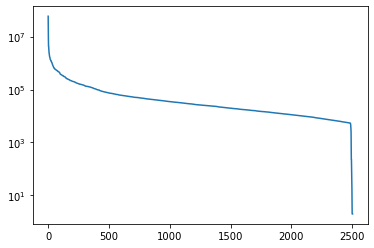

In [ ]:
plt.yscale('log')
sorted_occurences=sorted(list(count.values())[:],reverse=True)
plt.plot(sorted_occurences)

In [ ]:
model.reformer.embeddings.word_embeddings

Embedding(320, 256)

In [ ]:
model.reformer.embeddings.word_embeddings = nn.Embedding(2500+1+8192,256) #2500 for text, 1 for text-image seperator, and 8192 for image tokens

In [ ]:
model.reformer.embeddings.word_embeddings(torch.tensor([1]))

tensor([[-4.1946e-01,  4.9123e-01,  3.8498e-01,  8.5276e-01, -9.1908e-01,
         -1.5736e+00, -2.2362e-02,  4.1302e-01,  7.3285e-01, -1.1675e+00,
          6.4781e-01, -1.5711e+00, -3.3564e-01, -7.0559e-01,  7.8933e-01,
         -2.4407e-01,  6.1994e-01,  5.0193e-01, -2.2990e+00, -3.8529e-01,
         -3.3411e-01,  2.7533e-01, -7.4459e-01,  7.1982e-01, -1.2971e+00,
          8.0288e-02, -4.7700e-01, -1.0892e+00,  1.8609e+00, -7.1943e-01,
          9.7351e-01,  9.0973e-01,  9.8432e-01, -2.9445e-01, -8.7343e-01,
         -1.5446e-01,  1.0554e+00, -1.5202e+00, -2.5082e-01,  8.3422e-01,
          9.7409e-01,  2.9008e-02, -1.0773e+00, -2.2323e+00,  3.4452e-01,
          1.2398e+00,  7.3605e-01, -3.8201e-01,  2.0042e+00,  1.3541e+00,
          1.0773e-01, -1.2630e+00, -3.5281e-02,  8.9678e-02, -5.8812e-01,
         -2.8601e+00, -3.7328e-01, -1.6324e+00,  1.4853e+00, -6.5805e-01,
          1.4411e-01, -2.5666e-03, -6.2326e-01, -2.1954e+00, -1.5672e+00,
         -6.6827e-01, -1.2707e-01, -6.

In [ ]:
tokenizer = tok

In [ ]:
tok

In [ ]:
SentencePieceTokenizer??

In [ ]:
with open('vocab' + '.pkl', 'wb') as f: pickle.dump(list(count.keys()), f, pickle.HIGHEST_PROTOCOL)

In [ ]:
list(count.keys())

['▁xxbos',
 '▁2',
 'girls',
 '▁',
 'al',
 'bu',
 'm',
 '_',
 'cover',
 '▁artist',
 'request',
 '▁bangs',
 '▁blunt',
 'bangs',
 '▁brown',
 'hair',
 '▁cover',
 '▁earrings',
 '▁hair',
 'bun',
 '▁hime',
 'cut',
 'japanese',
 'clothes',
 '▁jewelry',
 '▁long',
 '▁mi',
 'yu',
 '_(',
 'va',
 'mp',
 'i',
 're',
 'princess',
 'mi',
 ')',
 '▁multiple',
 '▁red',
 'eyes',
 '▁ribbon',
 '▁v',
 'am',
 'pi',
 '▁wind',
 '▁yellow',
 '0',
 ':',
 '00',
 '▁1',
 'girl',
 '▁arm',
 'up',
 '▁bare',
 'shoulders',
 '▁bikini',
 'blonde',
 '▁blush',
 '▁breasts',
 '▁collarbone',
 'und',
 'panzer',
 '▁green',
 'between',
 '▁highres',
 '▁legs',
 '▁looking',
 'at',
 'viewer',
 '▁ma',
 'rie',
 '▁navel',
 '▁open',
 'mouth',
 '▁simple',
 'background',
 '▁solo',
 '▁standing',
 '▁swimsuit',
 '▁back',
 'lighting',
 '▁grey',
 'ornament',
 '▁kantai',
 'collection',
 'ken',
 'so',
 'gen',
 '▁lens',
 'flare',
 '▁pink',
 '▁sailor',
 'collar',
 '▁sa',
 'za',
 'nami',
 'kantai',
 '▁twintails',
 '▁wavy',
 'work',
 'in',
 'pro',
 'gr

In [ ]:
dss[0]

NameError: name 'dss' is not defined